In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2

**Dataste Citation:** Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.

## Load model

In [9]:
# Load the .h5 model
model_path = "../Retinal_Model.h5"  # Update this path
model = load_model(model_path, compile=False)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 21,069,740
No

### Compile model

In [10]:
# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Use your desired optimizer
              loss='categorical_crossentropy',  # Use your loss function
              metrics=['accuracy'])  # Use your desired metrics

### Define labels

In [11]:
labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

## Usage

### Preprocess image
Resize image to make it compatible to the model requeriments

In [12]:
def preprocess_image(image_path, target_size=(299, 299)):
    img = cv2.imread(image_path)  # Load image
    img = cv2.resize(img, target_size)  # Resize to match model input
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

### Prediction functions

In [13]:
def predict_image_probs(image_path, model, labels):
    """Returns probabilities for all classes."""
    img = preprocess_image(image_path)
    predictions = model.predict(img)[0]  # Get probabilities
    return {labels[i]: float(predictions[i]) for i in range(len(labels))}

def predict_image_label(image_path, model, labels):
    """Returns the most probable label and the full probability dictionary."""
    prediction_dict = predict_image_probs(image_path, model, labels)
    max_label = max(prediction_dict, key=prediction_dict.get)
    return max_label, prediction_dict  # Return both in one function call


### Test images

In [14]:
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
import json

Get images from the dataset [Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/3) Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.



In [1]:
folder_path = "../data/ZhangLabData/CellData/OCT/test"

# Get all image paths and their true labels from folder names
image_paths = []
true_labels = []

for label in os.listdir(folder_path):  # Each subfolder is a label (CNV, DME, etc.)
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):  # Ensure it's a folder
        for img_name in os.listdir(label_path):
            if img_name.endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(label_path, img_name))
                true_labels.append(label)  # Folder name is the true label

NameError: name 'os' is not defined

Classify images and save the results

In [ ]:
# Lists to store ground truth and predictions
y_true = []
y_pred = []

# Loop through each image, preprocess it, and make predictions
for img_path, true_label in zip(image_paths, true_labels):
    predicted_label, predicted_probs = predict_image_label(img_path, model, labels)

    # Store results for evaluation
    y_true.append(true_label)  # Ground truth label
    y_pred.append(predicted_label)  # Predicted label

    # # Load image for display
    # original_img = cv2.imread(img_path)

    # # Display image with filename and prediction
    # plt.figure(figsize=(6, 6))
    # plt.imshow(original_img)
    # plt.title(f"File: {os.path.basename(img_path)}\nPrediction: {predicted_label}\n{predicted_probs}")
    # plt.axis("off")  # Hide axes
    # plt.show()

# Convert labels to numerical format
y_true_numeric = [labels.index(label) for label in y_true]  # Convert class names to indices
y_pred_numeric = [labels.index(label) for label in y_pred]


Show test metrics

{
    "Total Images": 1000,
    "Accuracy": 0.973,
    "Precision": 0.9740174108047635,
    "Recall": 0.973,
    "F1 Score": 0.9729690267876736
}
Classification Report:
               precision    recall  f1-score   support

         CNV       0.93      0.99      0.96       250
         DME       0.98      1.00      0.99       250
      DRUSEN       0.98      0.92      0.95       250
      NORMAL       1.00      0.98      0.99       250

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



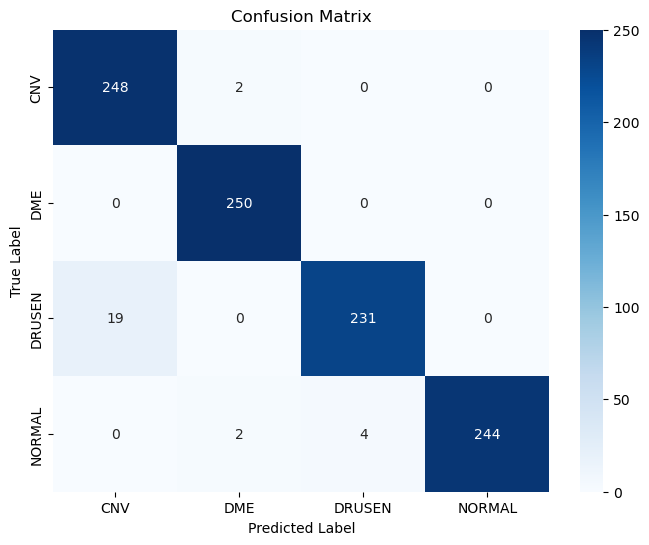

In [25]:
# Compute total images
total_images = len(y_true)

# Compute metrics
accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
precision = precision_score(y_true_numeric, y_pred_numeric, average="weighted")
recall = recall_score(y_true_numeric, y_pred_numeric, average="weighted")
f1 = f1_score(y_true_numeric, y_pred_numeric, average="weighted")

# Save metrics to a JSON file
metrics = {
    "Total Images": total_images,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

with open("../results/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Print evaluation metrics
print(json.dumps(metrics, indent=4))

# Save classification report
report = classification_report(y_true_numeric, y_pred_numeric, target_names=labels, output_dict=True)
with open("../results/classification_report.json", "w") as f:
    json.dump(report, f, indent=4)

# Print classification report
print("Classification Report:\n", classification_report(y_true_numeric, y_pred_numeric, target_names=labels))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_numeric, y_pred_numeric)

# Save confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("../results/confusion_matrix.png")  # Save as an image
plt.show()